In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

# hep.style.use('ROOT')

# Tagging using Custom Build NN with pytorch

In [2]:
def add_labels(z: float)->int:
    """
    Add labels according to the z vertex positon
    """
    if -800.0 < z and z < -500.0:
        return 0 # collimeter
    if -500.0 < z and z < -305.0:
        return 1 # air1
    if -305.0 < z and z < -295.0:
        return 2 # target
    if -295.0 < z and z < 0.0:
        return 3 # air2
    if 0.0 < z and z < 250.0:
        return 4 # beam dump
    else:
        return -99 # some error check the conditions

In [3]:
df = pd.read_csv('events-200k.csv')

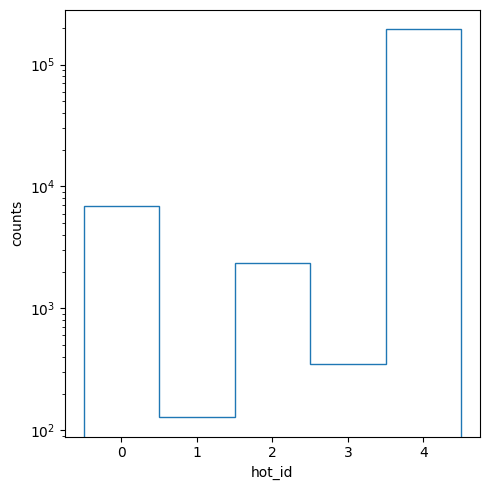

In [4]:
hot_id = df['vtz'].apply(add_labels).to_numpy()

plt.figure(figsize=(5, 5))
plt.hist(hot_id, bins=5, range=[-0.5, 4.5], histtype='step')
plt.yscale('log')
plt.xlabel('hot_id')
plt.ylabel('counts')
plt.tight_layout()
plt.show()

In [5]:
X = df[['q1', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'px1', 'py1', 'pz1', 'px2', 'py2', 'pz2']].to_numpy()
y = df[['vtx', 'vty', 'vtz', 'vpx', 'vpy', 'vpz']].to_numpy()

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
hot_id = ohe.fit_transform(hot_id.reshape(-1, 1))

In [7]:
from sklearn.model_selection import train_test_split

# train, validate test split
X_train_val, X_test, y_train_val, y_test, hotid_train_val, hotid_test = train_test_split(X, y, hot_id, test_size=0.2)
X_train, X_valid, y_train, y_valid, hotid_train, hotid_valid = train_test_split(X_train_val, y_train_val, hotid_train_val, test_size=0.25)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [9]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

class vertexTag(torch.nn.Module):
    def __init__(self, in_features: int=13, out_features: int=5, hidden_dim: int=64):
        super(vertexTag, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_dim, bias=True)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc4 = torch.nn.Linear(hidden_dim, out_features, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.log_softmax(self.fc4(x), dim=1)
        x = self.fc4(x)
        return x

In [10]:
class vertexReg(torch.nn.Module):
    def __init__(self, in_features: int=13, out_features: int=6, hidden_dim: int=32):
        super(vertexReg, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_dim, bias=True)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc4 = torch.nn.Linear(hidden_dim, out_features, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc4(x)
        return x

In [11]:
class vertexMLP(torch.nn.Module):
    def __init__(self, in_features: int=13, hotid_dim: int=5, vert_dim: int=6, hidden_dim1: int=64, hidden_dim2: int=64):
        super(vertexMLP, self).__init__()
        self.fc1 = vertexTag(in_features, hotid_dim, hidden_dim1)
        self.fc2 = vertexReg(in_features+hotid_dim, vert_dim, hidden_dim2)
        
    def forward(self, x):
        pred_hotid = self.fc1(x)
        pred_vert = self.fc2(torch.cat([x, pred_hotid], axis=-1))
        return pred_hotid, pred_vert

In [12]:
net = vertexMLP(hidden_dim1=32, hidden_dim2=64)
print(net)

vertexMLP(
  (fc1): vertexTag(
    (fc1): Linear(in_features=13, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=5, bias=True)
  )
  (fc2): vertexReg(
    (fc1): Linear(in_features=18, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=6, bias=True)
  )
)


In [13]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(hotid_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid), torch.Tensor(hotid_valid))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':1.5f'):
        self.name = name
        self.fmt = fmt
        self.reset()
        
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
    def __str__(self):
        fmtstr = '{avg' + self.fmt + '} ({name})'
        return fmtstr.format(**self.__dict__)

In [15]:
tag_criterion = torch.nn.CrossEntropyLoss()
reg_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5.0e-03, weight_decay=1.0e-05)
epochs = 150

In [16]:
tag_acc, tag_loss = AverageMeter('TagAccuracy'), AverageMeter('TagLoss')
reg_acc, reg_loss = AverageMeter('RegAccuracy'), AverageMeter('RegLoss')
tag_train_loss, tag_val_acc, tag_val_loss = [], [], []
reg_train_loss, reg_val_acc, reg_val_loss = [], [], []

# Iterate over the dataset <epochs> times
for epoch in range(epochs):
    
    alpha = 5.0e-04

    # Set the model to training mode
    net.train()
    # Reset our meters
    tag_loss.reset()
    tag_acc.reset()
    reg_loss.reset()

    # Iterate over batches
    for inputs, targets, hot_id in train_dataloader:

        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        pred_hotid, pred_vtx = net(inputs)

        # Compute the loss and accuracy
        tag_loss_batch = tag_criterion(pred_hotid, hot_id)
        tag_loss.update(tag_loss_batch.data)
        
        preds = torch.argmax(pred_hotid, dim=-1)
        accuracy = (torch.argmax(hot_id, dim=-1) == preds).sum() / len(hot_id)
        tag_acc.update(accuracy.data)
        
        # define some masks
        # msk = (preds != 0) & (torch.argmax(targets[:, 6:], dim=-1) == preds)
        
        reg_loss_batch = reg_criterion(pred_vtx, targets)
        reg_loss.update(reg_loss_batch.data)
        
        total_loss_batch = tag_loss_batch + alpha* reg_loss_batch

        # Compute the gradients
        total_loss_batch.backward()

        # Update parameters
        optimizer.step()
        
    tag_train_loss.append(tag_loss.avg)
    reg_train_loss.append(reg_loss.avg)
    
    # Validation for each epoch
    net.eval()
    tag_loss.reset()
    tag_acc.reset()
    reg_loss.reset()

    for inputs, targets, hot_id in val_dataloader:

        pred_hotid, pred_vtx = net(inputs)

        tag_loss_batch = tag_criterion(pred_hotid, hot_id)
        tag_loss.update(tag_loss_batch.data)

        preds = torch.argmax(pred_hotid, dim=-1)
        accuracy = (torch.argmax(hot_id, dim=-1) == preds).sum() / len(hot_id)
        tag_acc.update(accuracy.data)
        
        # define some masks
        # msk = (preds != 0) & (torch.argmax(targets[:, 6:], dim=-1) == preds)
        
        # reg_loss_batch =reg_criterion(pred_vtx[msk], targets[:, :6][msk])
        reg_loss_batch =reg_criterion(pred_vtx, targets)
        reg_loss.update(reg_loss_batch.data)
        
        # total_loss_batch = tag_loss_batch + alpha* reg_loss_batch

    tag_val_loss.append(tag_loss.avg)
    tag_val_acc.append(tag_acc.avg)
    reg_val_loss.append(reg_loss.avg)

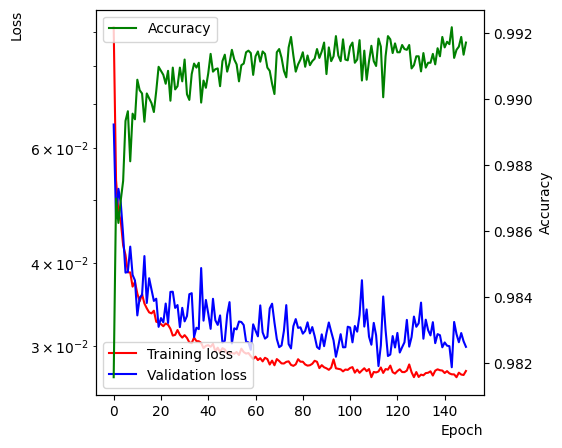

In [17]:
def draw_loss(data_train, data_val, data_acc, label="Loss"):
    """Plots the training and validation loss"""

    fig, ax1 = plt.subplots(figsize=(5, 5))
    ax1.set_xlabel("Epoch", horizontalalignment='right', x=1.0)
    ax1.set_ylabel("Loss", horizontalalignment='right', y=1.0)
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.plot(data_train,
             color='red',
             label='Training loss')
    ax1.plot(data_val,
             color='blue',
             label='Validation loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.plot(data_acc,
             color='green',
             label='Accuracy')
    ax1.legend(loc='lower left')
    ax2.legend(loc='upper left')
    # plt.tight_layout()
    plt.show()

draw_loss(tag_train_loss, tag_val_loss, tag_val_acc)

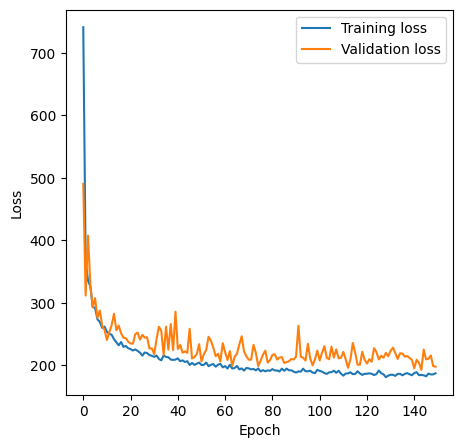

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(reg_train_loss, label='Training loss')
plt.plot(reg_val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import accuracy_score

pred_hotid, y_pred = net(torch.tensor(X_test).unsqueeze(0).float())

print("Accuracy for the test set: {0:.4f}".format(
    accuracy_score(
        np.argmax(hotid_test, axis=1),
        torch.argmax(pred_hotid, dim=-1).squeeze().numpy())
))

Accuracy for the test set: 0.9918


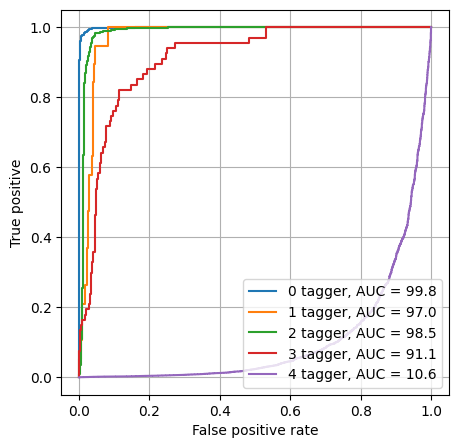

In [20]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_test, y_pred, labels):
    for x in range(5):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(labels[0][x], auc(fpr, tpr)*100.), linestyle='-')
    # plt.semilogy()
    plt.xlabel("False positive rate")
    plt.ylabel("True positive")
    # plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='lower right')  
    
plt.figure(figsize=(5, 5))
plot_roc(hotid_test, pred_hotid.squeeze().detach().numpy(), ohe.categories_)

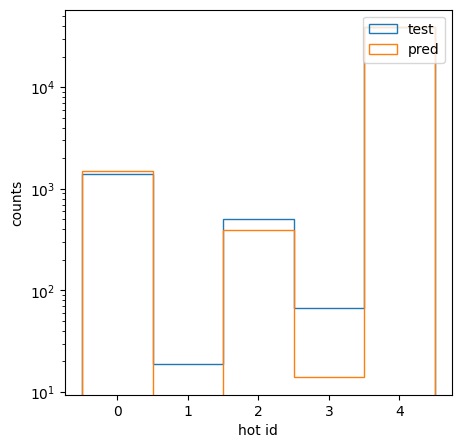

In [21]:
pred_hotid = torch.argmax(pred_hotid, dim=-1).squeeze().detach().numpy()
hotid_test = np.argmax(hotid_test, axis=1)


plt.figure(figsize=(5, 5))
plt.hist(hotid_test, histtype='step', bins=5, range=(-0.5, 4.5), label='test')
plt.hist(pred_hotid, histtype='step', bins=5, range=(-0.5, 4.5), label='pred')
plt.xlabel('hot id')
plt.ylabel('counts')
plt.legend()
plt.yscale('log')
# plt.tight_layout()
# plt.savefig('imgs/cls-hot-id.png')
plt.show()

In [22]:
def plot_reg(test_data, pred_data, label_x, nbin, bin_range):
    plt.figure(figsize=(5, 5))
    plt.hist(test_data, label='Test data', histtype='step', bins=nbin, range=bin_range)
    plt.hist(pred_data, label='Prediction data', histtype='step', bins=nbin, range=bin_range)
    plt.ylabel('counts')
    plt.xlabel(label_x)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [23]:
pred_y = y_pred.squeeze().detach().numpy()

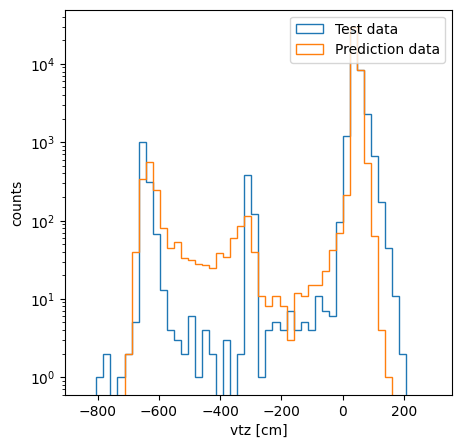

In [24]:
plot_reg(y_test[:, 2], pred_y[:, 2], 'vtz [cm]', 50, [-850, 300])